In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
#importing libraries to be used
import tensorflow as tf
import numpy as np
import math
import datetime
import platform
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
keras.backend.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger


In [3]:
#loading training and test set provided
train_set = pd.read_csv('../input/digit-recognizer/train.csv')
test_set = pd.read_csv('../input/digit-recognizer/test.csv')


In [4]:
#checking the shape of train dataset
print(train_set.shape)

(42000, 785)


In [5]:
#visualize strucutre of test set
train_set.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#visualize strucutre of test set
test_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#based on visualization above:
y_train = train_set['label'] #y_train is column titled label which has outputs(y)
del train_set['label'] #delete outputs y from dataset
x_train = train_set.values #x_train now dataset without 'label' column
#extract test set data
x_test = test_set.values #values in dataframe of test_set assigned to 'x_test'


In [8]:
#transform categorical data in y_train to a numpy array (binary class matrix)
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=10, dtype='float32'
)

In [9]:
#view y_train
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

#reshaping data 
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


In [11]:
#training(90%) and validation(10%) data split
x_train,x_val,y_train,y_val = train_test_split(x_train,
                                               y_train,
                                               test_size = 0.1,
                                               random_state = 0)

In [12]:
#creating noise data to reduce overfitting and generalize more
#noise = np.random.randint(0,100, (len(x_train),784))

In [13]:
#adding noise to x_train
#x_train = x_train+noise

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(37800, 28, 28, 1)
(37800, 10)
(4200, 28, 28, 1)
(4200, 10)


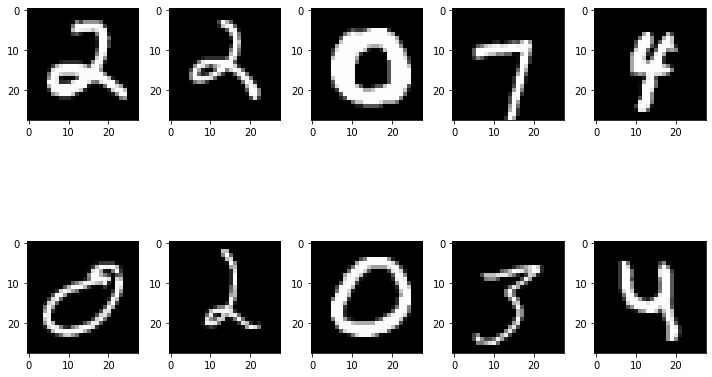

In [15]:
#visualize train_set images
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [16]:
#including data augmentation using imagedatagenerator
data_generator = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image by 10%
        width_shift_range=0.11,  # randomly shift width horizontally by 10%
        height_shift_range=0.11,  # randomly shift width horizontally by 10%
        )  




In [17]:
data_generator.fit(x_train) #include augmented data to processed training set

In [18]:
#using ReduceLROnPlateau for better val accuratcy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [19]:
#create model for training
model = Sequential()
model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 10 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

2022-11-21 00:56:40.966257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:56:40.967197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:56:41.200509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:56:41.201314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:56:41.202062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       16512     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       6

In [20]:
training_history = model.fit(data_generator.flow(x_train,y_train, batch_size = 64),
                             epochs = 37,
                             validation_data=(x_val, y_val),
                             callbacks=[learning_rate_reduction] 
                            )

2022-11-21 00:56:46.465117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/37


2022-11-21 00:56:49.247707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


591/591 [==============================] - 26s 22ms/step - loss: 0.2741 - accuracy: 0.9159 - val_loss: 0.1670 - val_accuracy: 0.9450
Epoch 2/37
591/591 [==============================] - 12s 21ms/step - loss: 0.0955 - accuracy: 0.9712 - val_loss: 0.0684 - val_accuracy: 0.9807
Epoch 3/37
591/591 [==============================] - 13s 22ms/step - loss: 0.0758 - accuracy: 0.9779 - val_loss: 0.0431 - val_accuracy: 0.9864
Epoch 4/37
591/591 [==============================] - 12s 21ms/step - loss: 0.0655 - accuracy: 0.9811 - val_loss: 0.0392 - val_accuracy: 0.9857
Epoch 5/37
591/591 [==============================] - 12s 21ms/step - loss: 0.0558 - accuracy: 0.9831 - val_loss: 0.0498 - val_accuracy: 0.9831
Epoch 6/37
591/591 [==============================] - 12s 20ms/step - loss: 0.0543 - accuracy: 0.9846 - val_loss: 0.0433 - val_accuracy: 0.9867
Epoch 7/37
591/591 [==============================] - 12s 21ms/step - loss: 0.0524 - accuracy: 0.9842 - val_loss: 0.0907 - val_accuracy: 0.9721
Epo

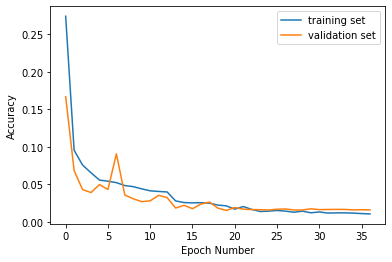

In [21]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.legend()

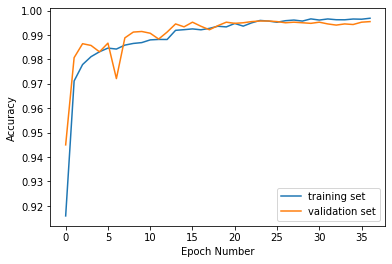

In [22]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='validation set')
plt.legend()

In [23]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)

1182/1182 [==============================] - 5s 4ms/step - loss: 0.0044 - accuracy: 0.9988


In [24]:
print('Train loss: ', train_loss)
print('Train accuracy: ', train_accuracy)

Train loss:  0.004422479309141636
Train accuracy:  0.9987565875053406


In [25]:
validation_loss, validation_accuracy = model.evaluate(x_val, y_val)

132/132 [==============================] - 1s 4ms/step - loss: 0.0160 - accuracy: 0.9955


In [26]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

Validation loss:  0.01597544550895691
Validation accuracy:  0.9954761862754822


In [27]:
model_name = 'digit_recognition_cnn_v8.h5'
model.save(model_name, save_format='h5')


In [28]:
load_model = tf.keras.models.load_model(model_name)

In [29]:
predictions_one_hot = load_model.predict([x_test])
print('predictions_one_hot:', predictions_one_hot.shape)

predictions_one_hot: (28000, 10)


In [30]:
test_pred = pd.DataFrame( load_model.predict([x_test]))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [31]:
test_pred.to_csv('submission.csv', index = False)